# Libraries

In [50]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from models.resnet import *
from utils import *

In [51]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=3)

# Configuration

In [52]:
class CFG:
    debug = False
    num_workers = 4
    batch_size = 128
    epochs = 163
    lr = 0.1
    weight_decay = 5e-4
    seed = 27
    
    # Factor Transfer
    rate = 0.5
    beta = 500
    
    #Multistep Scheduler
    milestones = [82, 123]
    gamma = 0.1
    
    #LOGS
    LOGS_DIR = './logs'

In [53]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# Dataset

In [54]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [55]:
BASE_DIR = "cifar-10-batches-py"

In [56]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [57]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=CFG.seed)

In [58]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [59]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomCrop(32),
                    transforms.RandomHorizontalFlip(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [60]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [61]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


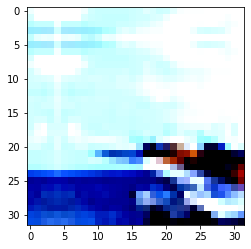

In [62]:
show_img(train_dataset[9])

In [63]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [64]:
test_dataset = CifarDataset(data, labels, transform_test)

In [65]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

# Model

In [80]:
teacher_model = ResNet56()
student_model = ResNet20()

teacher_model.to(device)
student_model.to(device)

ResNet_simple(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [87]:
teacher_model.load_state_dict(torch.load("./last_model_resnet20.pt"))

<All keys matched successfully>

# Helper Functions

In [68]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Paraphraser

In [69]:
paraphraser = Paraphraser(64, int(64*CFG.rate))
paraphraser.to(device)

Paraphraser(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [70]:
paraphraser.load_state_dict(torch.load('./paraphraser_resnet56_2.pt'))

<All keys matched successfully>

# Translator

In [71]:
translator = Translator(64, int(64*CFG.rate))
translator.to(device)

Translator(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Loss Function

In [72]:
ft_loss = FTLoss(CFG.beta, nn.L1Loss(), nn.CrossEntropyLoss())

# Training

In [73]:
def train_fn(train_loader, teacher_model, student_model, paraphraser, translator, criterion, epoch, optimizer, optimizer_translator, device):
    """
    Training a single epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    teacher_model.eval()
    paraphraser.eval()
    student_model.train()
    translator.train()
    
    
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        batch_size = labels.size(0)

        outputs_teacher = teacher_model(images)
        outputs_student = student_model(images)

        factor_teacher = paraphraser(outputs_teacher[2],1)
        factor_student = translator(outputs_student[2])
        
        loss = criterion(factor_teacher, factor_student, outputs_student[3], labels)
        
        losses.update(loss.item(), batch_size)

        loss.backward()
        
        optimizer.step()
        optimizer_translator.step()
        optimizer.zero_grad()
        optimizer_translator.zero_grad()
        
        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

In [74]:
def valid_fn(test_loader, teacher_model, student_model, paraphraser, translator, criterion, epoch, optimizer, optimizer_translator, device):
    """
    Validate after training an epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    teacher_model.eval()
    paraphraser.eval()
    student_model.eval()
    translator.eval()
    
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        batch_size = labels.size(0)

        with torch.no_grad():
            outputs_teacher = teacher_model(images)
            outputs_student = student_model(images)

            factor_teacher = paraphraser(outputs_teacher[2],1)
            factor_student = translator(outputs_student[2])
        
        loss = criterion(factor_teacher, factor_student, outputs_student[3], labels)

        losses.update(loss.item(), batch_size)

        preds.append(outputs_student[3].softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return losses.avg, score

In [75]:
optimizer = SGD(student_model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
scheduler = MultiStepLR(optimizer, milestones=CFG.milestones, gamma=CFG.gamma)
optimizer_translator = SGD(translator.parameters(), CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
scheduler_translator = MultiStepLR(optimizer_translator, milestones=CFG.milestones, gamma=CFG.gamma)

In [33]:
best_score = 0

for epoch in range(CFG.epochs):
    
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, teacher_model, student_model, paraphraser, translator, ft_loss, epoch, optimizer, optimizer_translator, device)
    avg_val_loss, score = valid_fn(valid_loader, teacher_model, student_model, paraphraser, translator, ft_loss, epoch, optimizer, optimizer_translator, device)
    
    scheduler.step()
    scheduler_translator.step()
    
    print(f"Epoch {epoch+1}")
    print(f"Accuracy: {score} | Train loss: {avg_loss} | Valid loss: {avg_val_loss}")
    
    if score > best_score:
        # Save the model if the validation score is better
        print("YES")
        best_score = score
        torch.save(student_model.state_dict(), f"best_model_transfer.pt")
        
    elapsed = time.time() - start_time

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.75it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1
Accuracy: 0.4699519230769231 | Train loss: 7.390990709647154 | Valid loss: 7.280364268865341
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.72it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2
Accuracy: 0.633613782051282 | Train loss: 6.661586329468295 | Valid loss: 6.181974838941525
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.21it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3
Accuracy: 0.7235576923076923 | Train loss: 5.566221349938982 | Valid loss: 4.934780695499518
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.13it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4
Accuracy: 0.7433894230769231 | Train loss: 4.6200520537178065 | Valid loss: 4.583525278629401
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.83it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5
Accuracy: 0.782051282051282 | Train loss: 4.177750759314947 | Valid loss: 4.205705978931525
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.43it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6
Accuracy: 0.8094951923076923 | Train loss: 3.949223788035901 | Valid loss: 3.94917422074538
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.45it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7
Accuracy: 0.7928685897435898 | Train loss: 3.7893247237572303 | Valid loss: 3.9554445254497037



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.46it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8
Accuracy: 0.8000801282051282 | Train loss: 3.68197453191817 | Valid loss: 3.8814158256237326



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.55it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9
Accuracy: 0.8361378205128205 | Train loss: 3.597741146033306 | Valid loss: 3.74452988918011
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.95it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10
Accuracy: 0.8215144230769231 | Train loss: 3.5134667698134723 | Valid loss: 3.878099514887883



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.32it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11
Accuracy: 0.84375 | Train loss: 3.4736819246895294 | Valid loss: 3.6032372621389537
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.91it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12
Accuracy: 0.8349358974358975 | Train loss: 3.4102571540408664 | Valid loss: 3.6205785396771555



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.59it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13
Accuracy: 0.8467548076923077 | Train loss: 3.3750217653747296 | Valid loss: 3.5409330465854745
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.13it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14
Accuracy: 0.8733974358974359 | Train loss: 3.342791554594991 | Valid loss: 3.323281862796881
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.68it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15
Accuracy: 0.8421474358974359 | Train loss: 3.30203607415202 | Valid loss: 3.514197160036136



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.06it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 16
Accuracy: 0.8659855769230769 | Train loss: 3.268718861446761 | Valid loss: 3.341474698140071



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.63it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 17
Accuracy: 0.8764022435897436 | Train loss: 3.245379189140776 | Valid loss: 3.255539215528048
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.86it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 18
Accuracy: 0.8685897435897436 | Train loss: 3.228335266439324 | Valid loss: 3.37662079395392



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.47it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 19
Accuracy: 0.8747996794871795 | Train loss: 3.2050220551993434 | Valid loss: 3.2661482248550806



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.86it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 20
Accuracy: 0.8681891025641025 | Train loss: 3.199141604947908 | Valid loss: 3.3682440488766403



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.16it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 21
Accuracy: 0.8551682692307693 | Train loss: 3.1766202741878327 | Valid loss: 3.452220672216171



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.66it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 22
Accuracy: 0.8337339743589743 | Train loss: 3.177727329085695 | Valid loss: 3.5293099880218506



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.23it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 23
Accuracy: 0.8768028846153846 | Train loss: 3.1534176266770757 | Valid loss: 3.2603040230579867
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.64it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 24
Accuracy: 0.8651842948717948 | Train loss: 3.1502497114686885 | Valid loss: 3.441315559240488



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.15it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 25
Accuracy: 0.8597756410256411 | Train loss: 3.1451204971030906 | Valid loss: 3.4371422743185973



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.26it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 26
Accuracy: 0.8619791666666666 | Train loss: 3.1266808013970357 | Valid loss: 3.298853868093246



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.78it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 27
Accuracy: 0.8665865384615384 | Train loss: 3.126254313352101 | Valid loss: 3.254219745978331



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.70it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 28
Accuracy: 0.8501602564102564 | Train loss: 3.0956794339367466 | Valid loss: 3.465793028855935



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.65it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 29
Accuracy: 0.8711939102564102 | Train loss: 3.105208603405205 | Valid loss: 3.254004019957322



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.68it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 30
Accuracy: 0.8745993589743589 | Train loss: 3.093709996622852 | Valid loss: 3.1584295431772866



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 31
Accuracy: 0.8607772435897436 | Train loss: 3.0829774022441985 | Valid loss: 3.276045493590526



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 32
Accuracy: 0.8305288461538461 | Train loss: 3.0835478774502745 | Valid loss: 3.471337330647004



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 33
Accuracy: 0.8804086538461539 | Train loss: 3.0623404538189924 | Valid loss: 3.180692275365194
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.87it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 34
Accuracy: 0.8691907051282052 | Train loss: 3.077300006507808 | Valid loss: 3.3506295742132726



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.92it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 35
Accuracy: 0.8571714743589743 | Train loss: 3.0759813466303028 | Valid loss: 3.321849083289122



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 36
Accuracy: 0.8475560897435898 | Train loss: 3.0536754158487347 | Valid loss: 3.4817910438928847



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.89it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 37
Accuracy: 0.8832131410256411 | Train loss: 3.050027341924162 | Valid loss: 3.184595450376853
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.18it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 38
Accuracy: 0.8776041666666666 | Train loss: 3.0440630831270137 | Valid loss: 3.117262540719448



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.65it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 39
Accuracy: 0.8513621794871795 | Train loss: 3.0270585273405763 | Valid loss: 3.439566080386822



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.33it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 40
Accuracy: 0.8713942307692307 | Train loss: 3.039527104451106 | Valid loss: 3.2408965673202124



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 41
Accuracy: 0.8555689102564102 | Train loss: 3.046093982169431 | Valid loss: 3.2745923812572775



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.90it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 42
Accuracy: 0.8615785256410257 | Train loss: 3.055800960953759 | Valid loss: 3.358007583862696



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.78it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 43
Accuracy: 0.8655849358974359 | Train loss: 3.0072375892573953 | Valid loss: 3.298757161849584



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.73it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 44
Accuracy: 0.8697916666666666 | Train loss: 3.031532831001825 | Valid loss: 3.3194072246551514



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.53it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 45
Accuracy: 0.8729967948717948 | Train loss: 3.0212735233143864 | Valid loss: 3.138022074332604



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.77it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 46
Accuracy: 0.8565705128205128 | Train loss: 3.032391463929092 | Valid loss: 3.2351620502960987



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.49it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 47
Accuracy: 0.8671875 | Train loss: 3.0193029448517366 | Valid loss: 3.2377116619012294



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.62it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 48
Accuracy: 0.8629807692307693 | Train loss: 3.009228721982733 | Valid loss: 3.2788718724862123



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.20it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 49
Accuracy: 0.8754006410256411 | Train loss: 3.0089883668470248 | Valid loss: 3.1782014003166785



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.07it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 50
Accuracy: 0.8854166666666666 | Train loss: 3.0098432869653076 | Valid loss: 3.061317578340188
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 51
Accuracy: 0.8385416666666666 | Train loss: 3.004536996879469 | Valid loss: 3.452109660857763



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.21it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 52
Accuracy: 0.8613782051282052 | Train loss: 2.998816708893518 | Valid loss: 3.4749363324581046



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.84it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 53
Accuracy: 0.8627804487179487 | Train loss: 3.0068827911659524 | Valid loss: 3.2720744487566824



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.98it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 54
Accuracy: 0.8770032051282052 | Train loss: 2.986558698181413 | Valid loss: 3.1713875440450816



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.91it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 55
Accuracy: 0.8467548076923077 | Train loss: 3.002346948341087 | Valid loss: 3.388394832611084



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.94it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 56
Accuracy: 0.8649839743589743 | Train loss: 2.9959153273166756 | Valid loss: 3.304663444176698



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.99it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 57
Accuracy: 0.8639823717948718 | Train loss: 2.980730744168969 | Valid loss: 3.297565704736954



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.10it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 58
Accuracy: 0.8613782051282052 | Train loss: 3.0002449041078574 | Valid loss: 3.2698647731389756



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.84it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 59
Accuracy: 0.8603766025641025 | Train loss: 2.9766685412480283 | Valid loss: 3.4219514712309227



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.43it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 60
Accuracy: 0.8784054487179487 | Train loss: 2.9717611546530005 | Valid loss: 3.125020858569023



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.76it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 61
Accuracy: 0.8613782051282052 | Train loss: 2.9849498326282555 | Valid loss: 3.2832070925296883



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.62it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 62
Accuracy: 0.8627804487179487 | Train loss: 2.9888317686879735 | Valid loss: 3.1995818737225656



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.01it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 63
Accuracy: 0.8711939102564102 | Train loss: 2.98084326279469 | Valid loss: 3.184484084447225



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.11it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 64
Accuracy: 0.8926282051282052 | Train loss: 2.9740007562175435 | Valid loss: 3.1289409001668296
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.18it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 65
Accuracy: 0.8739983974358975 | Train loss: 2.9847774736562007 | Valid loss: 3.1537800079736953



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.57it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 66
Accuracy: 0.8794070512820513 | Train loss: 2.970221410789381 | Valid loss: 3.09906591513218



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.16it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 67
Accuracy: 0.8854166666666666 | Train loss: 2.9657948200519266 | Valid loss: 3.106050106195303



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.64it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 68
Accuracy: 0.8611778846153846 | Train loss: 2.9784638365449387 | Valid loss: 3.3386220993139806



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.33it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 69
Accuracy: 0.8854166666666666 | Train loss: 2.9712195539066935 | Valid loss: 3.091971366833418



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.15it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 70
Accuracy: 0.8926282051282052 | Train loss: 2.9590941161511632 | Valid loss: 3.0483777156242957



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.27it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 71
Accuracy: 0.8581730769230769 | Train loss: 2.9586518109693825 | Valid loss: 3.323246772472675



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.25it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 72
Accuracy: 0.8844150641025641 | Train loss: 2.957295183442597 | Valid loss: 3.096303206223708



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.18it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 73
Accuracy: 0.8639823717948718 | Train loss: 2.9792418547844957 | Valid loss: 3.223586021325527



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.02it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 74
Accuracy: 0.8810096153846154 | Train loss: 2.9606919363353326 | Valid loss: 3.134518556105785



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.74it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 75
Accuracy: 0.8579727564102564 | Train loss: 2.953296348240301 | Valid loss: 3.2685300081204147



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.58it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 76
Accuracy: 0.8571714743589743 | Train loss: 2.965641302260918 | Valid loss: 3.363405478306306



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.16it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 77
Accuracy: 0.8623798076923077 | Train loss: 2.9545417178390374 | Valid loss: 3.2174305487901735



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.84it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 78
Accuracy: 0.8938301282051282 | Train loss: 2.956634895074741 | Valid loss: 3.0486493416321583
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.29it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 79
Accuracy: 0.8838141025641025 | Train loss: 2.9479150228690556 | Valid loss: 3.1161507031856437



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.53it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 80
Accuracy: 0.8858173076923077 | Train loss: 2.953594851018357 | Valid loss: 3.135049214729896



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.51it/s]

Adjusting learning rate of group 0 to 1.0000e-01.
Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 81
Accuracy: 0.8747996794871795 | Train loss: 2.9588862633773063 | Valid loss: 3.320830938143608



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.36it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 82
Accuracy: 0.8183092948717948 | Train loss: 2.932642000013607 | Valid loss: 3.56407616688655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.55it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 83
Accuracy: 0.9318910256410257 | Train loss: 2.5489453712419907 | Valid loss: 2.459845029390775
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.53it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 84
Accuracy: 0.9332932692307693 | Train loss: 2.43181829235153 | Valid loss: 2.4236682928525486
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.77it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 85
Accuracy: 0.9354967948717948 | Train loss: 2.3949642677252787 | Valid loss: 2.398051237448668
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.74it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 86
Accuracy: 0.9354967948717948 | Train loss: 2.3652671504224467 | Valid loss: 2.3739401254898462



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.26it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 87
Accuracy: 0.9338942307692307 | Train loss: 2.3463989295850793 | Valid loss: 2.360808036266229



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.04it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 88
Accuracy: 0.9379006410256411 | Train loss: 2.3339478772589963 | Valid loss: 2.3674861039870825
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.20it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 89
Accuracy: 0.936698717948718 | Train loss: 2.321128475700009 | Valid loss: 2.350743593313755



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.91it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 90
Accuracy: 0.9348958333333334 | Train loss: 2.3088753535876587 | Valid loss: 2.355155993730594



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.75it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 91
Accuracy: 0.9350961538461539 | Train loss: 2.3047445227957177 | Valid loss: 2.349116013600276



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.20it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 92
Accuracy: 0.9350961538461539 | Train loss: 2.3014700338032172 | Valid loss: 2.339707839183318



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.03it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 93
Accuracy: 0.9375 | Train loss: 2.2913877773828317 | Valid loss: 2.339893157665546



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.02it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 94
Accuracy: 0.9340945512820513 | Train loss: 2.2846360464720985 | Valid loss: 2.3416216312310634



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.99it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 95
Accuracy: 0.9358974358974359 | Train loss: 2.2783342487791662 | Valid loss: 2.342076356594379



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.56it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 96
Accuracy: 0.9348958333333334 | Train loss: 2.2753372233138127 | Valid loss: 2.342048314901499



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.36it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 97
Accuracy: 0.9352964743589743 | Train loss: 2.2745962265210276 | Valid loss: 2.343642674959623



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.16it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 98
Accuracy: 0.9326923076923077 | Train loss: 2.2675228737018727 | Valid loss: 2.3424756771478896



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.86it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 99
Accuracy: 0.9332932692307693 | Train loss: 2.270629378125878 | Valid loss: 2.3536043350513163



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.43it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 100
Accuracy: 0.9364983974358975 | Train loss: 2.26205904531343 | Valid loss: 2.3649924168219933



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.42it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 101
Accuracy: 0.9324919871794872 | Train loss: 2.2621212039577996 | Valid loss: 2.3652123304513784



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.89it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 102
Accuracy: 0.9368990384615384 | Train loss: 2.26168808706126 | Valid loss: 2.3499234517415366



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.32it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 103
Accuracy: 0.9362980769230769 | Train loss: 2.253819712886104 | Valid loss: 2.33388920319386



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.25it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 104
Accuracy: 0.9332932692307693 | Train loss: 2.2532174641590172 | Valid loss: 2.387112965950599



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.03it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 105
Accuracy: 0.938301282051282 | Train loss: 2.2587280090038595 | Valid loss: 2.3507338548317933
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.85it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 106
Accuracy: 0.9328926282051282 | Train loss: 2.2575683288085155 | Valid loss: 2.3472891648610434



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.22it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 107
Accuracy: 0.9320913461538461 | Train loss: 2.25630019940542 | Valid loss: 2.4024481039780836



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.50it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 108
Accuracy: 0.9328926282051282 | Train loss: 2.255038031825313 | Valid loss: 2.393679875593919



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.78it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 109
Accuracy: 0.9360977564102564 | Train loss: 2.2573317421807184 | Valid loss: 2.3541982907515306



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.65it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 110
Accuracy: 0.9326923076923077 | Train loss: 2.2560190746926856 | Valid loss: 2.3525122618063903



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.65it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 111
Accuracy: 0.9379006410256411 | Train loss: 2.2534748475436133 | Valid loss: 2.348308722178141



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.31it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 112
Accuracy: 0.9330929487179487 | Train loss: 2.261601612438843 | Valid loss: 2.373489703887548



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.53it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 113
Accuracy: 0.9350961538461539 | Train loss: 2.255931484733212 | Valid loss: 2.3616682382730336



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.31it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 114
Accuracy: 0.9348958333333334 | Train loss: 2.2563647164238825 | Valid loss: 2.374763928926908



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.27it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 115
Accuracy: 0.9314903846153846 | Train loss: 2.2624509320979103 | Valid loss: 2.3659678483620667



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.58it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 116
Accuracy: 0.9332932692307693 | Train loss: 2.2615845590575128 | Valid loss: 2.4050381428156142



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.42it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 117
Accuracy: 0.9316907051282052 | Train loss: 2.256196294415031 | Valid loss: 2.414859197078607



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.87it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 118
Accuracy: 0.9352964743589743 | Train loss: 2.26386585534468 | Valid loss: 2.3701837185101633



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.28it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 119
Accuracy: 0.9360977564102564 | Train loss: 2.26088800185766 | Valid loss: 2.3878471362285123



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.09it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 120
Accuracy: 0.9296875 | Train loss: 2.2572869242426337 | Valid loss: 2.465757828492385



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.22it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 121
Accuracy: 0.9250801282051282 | Train loss: 2.263309463136896 | Valid loss: 2.44130190824851



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.75it/s]

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 122
Accuracy: 0.9362980769230769 | Train loss: 2.2604744644925803 | Valid loss: 2.379030838990823



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.63it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 123
Accuracy: 0.9310897435897436 | Train loss: 2.2615575763235065 | Valid loss: 2.4007920179611597



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.14it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 124
Accuracy: 0.9399038461538461 | Train loss: 2.155252117716689 | Valid loss: 2.2392357801779723
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.61it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 125
Accuracy: 0.9395032051282052 | Train loss: 2.1301137599510347 | Valid loss: 2.2334334819744797



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.43it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 126
Accuracy: 0.9395032051282052 | Train loss: 2.115104566612135 | Valid loss: 2.226496941004044



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.40it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 127
Accuracy: 0.9419070512820513 | Train loss: 2.110264374999239 | Valid loss: 2.225801327289679
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.12it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 128
Accuracy: 0.9411057692307693 | Train loss: 2.110812024513201 | Valid loss: 2.21783954057938



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.75it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 129
Accuracy: 0.9425080128205128 | Train loss: 2.1070585298402356 | Valid loss: 2.218821971844404
YES


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.33it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 130
Accuracy: 0.9409054487179487 | Train loss: 2.105892454796707 | Valid loss: 2.2180588184258876



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.41it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 131
Accuracy: 0.9429086538461539 | Train loss: 2.101072882315372 | Valid loss: 2.2138590812683105
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.32it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 132
Accuracy: 0.9421073717948718 | Train loss: 2.1008868431433654 | Valid loss: 2.2139679346329126



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.08it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 133
Accuracy: 0.9407051282051282 | Train loss: 2.098427982411833 | Valid loss: 2.2196003168057175



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.80it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 134
Accuracy: 0.9405048076923077 | Train loss: 2.0944500577415837 | Valid loss: 2.2152892381716995



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.46it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 135
Accuracy: 0.9439102564102564 | Train loss: 2.096214624891254 | Valid loss: 2.2161622169690256
YES



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.45it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 136
Accuracy: 0.9421073717948718 | Train loss: 2.0959492307103256 | Valid loss: 2.215371009631035



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.68it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 137
Accuracy: 0.9413060897435898 | Train loss: 2.094806313175082 | Valid loss: 2.2096018424400916



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.39it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 138
Accuracy: 0.9419070512820513 | Train loss: 2.093864043893298 | Valid loss: 2.2152573940081473



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.14it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 139
Accuracy: 0.9411057692307693 | Train loss: 2.0866503637400786 | Valid loss: 2.2099135227692432



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.13it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 140
Accuracy: 0.9407051282051282 | Train loss: 2.090629002307555 | Valid loss: 2.2134832724546776



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.87it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 141
Accuracy: 0.9415064102564102 | Train loss: 2.0886282316300266 | Valid loss: 2.2062768385960507



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.02it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 142
Accuracy: 0.9423076923076923 | Train loss: 2.0893432204200333 | Valid loss: 2.2073082557091346



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.66it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 143
Accuracy: 0.9415064102564102 | Train loss: 2.0855676017255864 | Valid loss: 2.217746343368139



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 19.48it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 144
Accuracy: 0.9401041666666666 | Train loss: 2.086126655934543 | Valid loss: 2.209525615741045



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.49it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 145
Accuracy: 0.9415064102564102 | Train loss: 2.0822254538196443 | Valid loss: 2.2115328250787196



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.09it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 146
Accuracy: 0.9411057692307693 | Train loss: 2.082696309796086 | Valid loss: 2.206392948444073



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.93it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 147
Accuracy: 0.9437099358974359 | Train loss: 2.084408869770517 | Valid loss: 2.2086815344981656



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.63it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 148
Accuracy: 0.9421073717948718 | Train loss: 2.082933266617973 | Valid loss: 2.211690597045116



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.19it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 149
Accuracy: 0.9409054487179487 | Train loss: 2.0814289791971192 | Valid loss: 2.2053538163503013



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.37it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 150
Accuracy: 0.9417067307692307 | Train loss: 2.0808040562518304 | Valid loss: 2.207279229775453



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.63it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 151
Accuracy: 0.9433092948717948 | Train loss: 2.0823035759803576 | Valid loss: 2.2066889665065665



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.33it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 152
Accuracy: 0.9409054487179487 | Train loss: 2.077973041778956 | Valid loss: 2.2110439202724357



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.07it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 153
Accuracy: 0.9407051282051282 | Train loss: 2.079131191272681 | Valid loss: 2.207355694893079



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.72it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 154
Accuracy: 0.9425080128205128 | Train loss: 2.0794796739887986 | Valid loss: 2.20655886332194



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.61it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 155
Accuracy: 0.9419070512820513 | Train loss: 2.078050572648008 | Valid loss: 2.206608087588579



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.27it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 156
Accuracy: 0.9425080128205128 | Train loss: 2.0744402914644984 | Valid loss: 2.2091475816873403



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.26it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 157
Accuracy: 0.9409054487179487 | Train loss: 2.0778768561844134 | Valid loss: 2.206319264876537



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.97it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 158
Accuracy: 0.9419070512820513 | Train loss: 2.0748236980872954 | Valid loss: 2.20860165816087



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.20it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 159
Accuracy: 0.9423076923076923 | Train loss: 2.074297968138996 | Valid loss: 2.2067491152347665



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.82it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 160
Accuracy: 0.9419070512820513 | Train loss: 2.0740040381070215 | Valid loss: 2.2062520186106362



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.78it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 161
Accuracy: 0.9423076923076923 | Train loss: 2.073354220797873 | Valid loss: 2.206337977678348



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.76it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 162
Accuracy: 0.9423076923076923 | Train loss: 2.071811327907095 | Valid loss: 2.207655277007665



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.84it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 163
Accuracy: 0.9415064102564102 | Train loss: 2.075102066382384 | Valid loss: 2.201929984948574


In [34]:
torch.save(student_model.state_dict(), f"last_model_transfer.pt")

In [45]:
student_model.load_state_dict(torch.load("./best_model_transfer.pt"))

<All keys matched successfully>

In [82]:
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [88]:
preds = []
valid_labels = []

student_model.eval()
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        outputs = student_model(images)
        
    preds.append(outputs[3].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 28.78it/s]
